# Results and Analysis

## Hierarchical Classification: Architecture Comparison

### Evaluation metrics: **Accuracy, Precision, Recall, F1-Score, AUC, ROC Curves**

In [1]:
import sys
sys.path.insert(0, '..')

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset, REGION_FINE_CLASS_COUNTS
from utils.hierarchical_model import HierarchicalClassificationModel

# Set matplotlib style for PGF export
matplotlib.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.size": 10,
})

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Test Data

In [2]:
# Load test data
train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Test samples: {dataset_info['test_samples']}")
print(f"Regions: {dataset_info['idx_to_region']}")

# Extract key info
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']
num_coarse_classes = len(region_idx_to_name)

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and 

## 2. Evaluate Stage 1 (Coarse) Models

Load models from `stage1_coarse_*.pth` files.

In [3]:
ARCHITECTURES_STAGE1 = ['efficientnet3d_b0', 'resnet18_3d', 'resnet34_3d', 'densenet121_3d', 'enhanced', 'base']

stage1_results = {}

print("=" * 60)
print("SCANNING FOR STAGE 1 (COARSE) MODELS")
print("=" * 60)

for arch in ARCHITECTURES_STAGE1:
    model_path = f"{PATHS['models']}/stage1_coarse_{arch}.pth"
    
    if os.path.exists(model_path):
        print(f"\nFound: {os.path.basename(model_path)}")
        
        try:
            # Create model
            model = HierarchicalClassificationModel(
                region_configs=region_configs,
                architecture=arch,
                coarse_model_type=arch,
                fine_model_type=arch,
                dropout_rate=MODEL_CONFIG['dropout_rate'],
                region_idx_to_name=region_idx_to_name,
                num_total_organs=dataset_info['num_fine_classes'],
                use_subtypes=False
            ).to(DEVICE)
            
            # Load weights
            checkpoint = torch.load(model_path, map_location=DEVICE)
            model.load_state_dict(checkpoint, strict=False)
            
            print(f"  -> Evaluating coarse classifier...")
            model.eval()
            
            all_preds, all_labels, all_probs = [], [], []
            
            with torch.no_grad():
                for imgs, coarse_labels, _ in tqdm(test_loader, desc=f"Stage1 {arch}"):
                    imgs = imgs.to(DEVICE, dtype=torch.float32)
                    if imgs.max() > 1:
                        imgs = imgs / 255.0
                    coarse_labels = coarse_labels.long().to(DEVICE)
                    
                    logits = model.forward_coarse(imgs)
                    probs = torch.softmax(logits, dim=1)
                    preds = logits.argmax(1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(coarse_labels.cpu().numpy())
                    all_probs.append(probs.cpu().numpy())
            
            y_true = np.array(all_labels)
            y_pred = np.array(all_preds)
            y_probs = np.concatenate(all_probs, axis=0)
            
            # Compute metrics
            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            
            # AUC
            try:
                y_true_bin = label_binarize(y_true, classes=list(range(num_coarse_classes)))
                auc_val = roc_auc_score(y_true_bin, y_probs, average='weighted', multi_class='ovr')
            except:
                auc_val = None
            
            stage1_results[arch] = {
                'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc_val,
                'predictions': y_pred, 'labels': y_true, 'probs': y_probs
            }
            print(f"  -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
            
        except Exception as e:
            print(f"  -> Error: {e}")

print(f"\nStage 1 models evaluated: {list(stage1_results.keys())}")

SCANNING FOR STAGE 1 (COARSE) MODELS

Found: stage1_coarse_efficientnet3d_b0.pth


/tmp/ipykernel_16081/3685729346.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating coarse classifier...


Stage1 efficientnet3d_b0: 100%|██████████| 230/230 [00:01<00:00, 150.99it/s]


  -> Accuracy: 0.9549, Precision: 0.9564, Recall: 0.9549, F1: 0.9550

Found: stage1_coarse_resnet18_3d.pth


/tmp/ipykernel_16081/3685729346.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating coarse classifier...


Stage1 resnet18_3d: 100%|██████████| 230/230 [00:01<00:00, 199.61it/s]


  -> Accuracy: 0.9739, Precision: 0.9743, Recall: 0.9739, F1: 0.9738

Found: stage1_coarse_densenet121_3d.pth


/tmp/ipykernel_16081/3685729346.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating coarse classifier...


Stage1 densenet121_3d: 100%|██████████| 230/230 [00:02<00:00, 94.15it/s] 
/tmp/ipykernel_16081/3685729346.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

  -> Accuracy: 0.9685, Precision: 0.9690, Recall: 0.9685, F1: 0.9684

Found: stage1_coarse_enhanced.pth
  -> Evaluating coarse classifier...


Stage1 enhanced: 100%|██████████| 230/230 [00:01<00:00, 115.89it/s]

  -> Accuracy: 0.9467, Precision: 0.9467, Recall: 0.9467, F1: 0.9465

Stage 1 models evaluated: ['efficientnet3d_b0', 'resnet18_3d', 'densenet121_3d', 'enhanced']


## 3. Evaluate Stage 2 (Fine) Models

Load models from `hierarchical_model_*.pth` files.

In [4]:

stage2_results = {}

ARCHITECTURES_STAGE2 = [
    'efficientnet3d_b0', 
    'efficientnet3d_b0_bare_metal', 
    'resnet18_3d', 
    'resnet34_3d', 
    'densenet121_3d', 
    'enhanced', 
    'enhanced_bare_metal', 
    'densenet121_3d_bare_metal', 
    'resnet18_3d_bare_metal', 
    'resnet34_3d_bare_metal']

print("=" * 60)
print("SCANNING FOR STAGE 2 (HIERARCHICAL) MODELS")
print("=" * 60)

for arch in ARCHITECTURES_STAGE2:
    base_arch = arch.replace('_bare_metal', '')
    
    # Try new format first
    model_path = f"{PATHS['models']}/hierarchical_model_{arch}.pth"
    if not os.path.exists(model_path):
        model_path = f"{PATHS['models']}/hierarchical_{arch}.pth"
    
    if os.path.exists(model_path):
        print(f"\nFound: {os.path.basename(model_path)}")
        
        try:
            model = HierarchicalClassificationModel(
                region_configs=region_configs,
                architecture=base_arch,
                coarse_model_type=base_arch,
                fine_model_type=base_arch,
                dropout_rate=MODEL_CONFIG['dropout_rate'],
                region_idx_to_name=region_idx_to_name,
                num_total_organs=dataset_info['num_fine_classes'],
                use_subtypes=False
            ).to(DEVICE)
            
            checkpoint = torch.load(model_path, map_location=DEVICE)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                model.load_state_dict(checkpoint)
            
            print(f"  -> Evaluating fine classifiers...")
            model.eval()
            
            # Storage for granular analysis and ROC curves
            region_results = {r: {'labels': [], 'preds': [], 'probs': []} 
                            for r in region_idx_to_name.values()}
            
            all_fine_preds, all_fine_labels = [], []
            
            with torch.no_grad():
                for imgs, coarse_labels, fine_labels in tqdm(test_loader, desc=f"Stage2 {arch}"):
                    imgs = imgs.to(DEVICE, dtype=torch.float32)
                    if imgs.max() > 1:
                        imgs = imgs / 255.0
                    coarse_labels = coarse_labels.long().to(DEVICE)
                    fine_labels = fine_labels.long().to(DEVICE)
                    
                    # Use ground truth routing for fine evaluation
                    for region_idx, region_name in region_idx_to_name.items():
                        mask = (coarse_labels == region_idx)
                        if not mask.any():
                            continue
                        
                        region_imgs = imgs[mask]
                        region_fine_labels = fine_labels[mask]
                        
                        fine_logits = model.forward_fine(region_imgs, region_name)
                        fine_probs = torch.softmax(fine_logits, dim=1)
                        fine_preds = fine_logits.argmax(1)
                        
                        # Store per-region results
                        region_results[region_name]['labels'].extend(region_fine_labels.cpu().numpy())
                        region_results[region_name]['probs'].extend(fine_probs.cpu().numpy())
                        region_results[region_name]['preds'].extend(fine_preds.cpu().numpy())
                        
                        all_fine_preds.extend(fine_preds.cpu().numpy())
                        all_fine_labels.extend(region_fine_labels.cpu().numpy())
            
            # Convert lists to arrays for per-region results
            for r_name in region_results:
                region_results[r_name]['labels'] = np.array(region_results[r_name]['labels'])
                region_results[r_name]['probs'] = np.concatenate(region_results[r_name]['probs'], axis=0) if region_results[r_name]['probs'] else np.array([])
                region_results[r_name]['preds'] = np.array(region_results[r_name]['preds'])
            
            y_true = np.array(all_fine_labels)
            y_pred = np.array(all_fine_preds)
            
            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            
            stage2_results[arch] = {
                'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
                'predictions': y_pred, 'labels': y_true,
                'per_region': region_results
            }
            print(f"  -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
            
        except Exception as e:
            print(f"  -> Error: {e}")
            import traceback
            traceback.print_exc()

print(f"\nStage 2 models evaluated: {list(stage2_results.keys())}")


/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


SCANNING FOR STAGE 2 (HIERARCHICAL) MODELS

Found: hierarchical_model_efficientnet3d_b0.pth
  -> Evaluating fine classifiers...


Stage2 efficientnet3d_b0: 100%|██████████| 230/230 [00:01<00:00, 125.75it/s]
/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint 

  -> Accuracy: 0.6196, Precision: 0.5092, Recall: 0.6196, F1: 0.5498

Found: hierarchical_model_efficientnet3d_b0_bare_metal.pth
  -> Evaluating fine classifiers...


Stage2 efficientnet3d_b0_bare_metal: 100%|██████████| 230/230 [00:01<00:00, 140.72it/s]


  -> Accuracy: 0.5935, Precision: 0.5657, Recall: 0.5935, F1: 0.5601

Found: hierarchical_model_resnet18_3d.pth


/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating fine classifiers...


Stage2 resnet18_3d: 100%|██████████| 230/230 [00:01<00:00, 160.07it/s]


  -> Accuracy: 0.6375, Precision: 0.6157, Recall: 0.6375, F1: 0.5696

Found: hierarchical_model_densenet121_3d.pth


/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating fine classifiers...


Stage2 densenet121_3d: 100%|██████████| 230/230 [00:03<00:00, 67.80it/s]
/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = to

  -> Accuracy: 0.5690, Precision: 0.4719, Recall: 0.5690, F1: 0.4741

Found: hierarchical_model_enhanced.pth
  -> Evaluating fine classifiers...


Stage2 enhanced: 100%|██████████| 230/230 [00:02<00:00, 104.89it/s]
/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

  -> Accuracy: 0.7918, Precision: 0.8040, Recall: 0.7918, F1: 0.7942

Found: hierarchical_model_enhanced_bare_metal.pth
  -> Evaluating fine classifiers...


Stage2 enhanced_bare_metal: 100%|██████████| 230/230 [00:02<00:00, 105.98it/s]


  -> Accuracy: 0.7473, Precision: 0.7790, Recall: 0.7473, F1: 0.7527

Found: hierarchical_model_densenet121_3d_bare_metal.pth


/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating fine classifiers...


Stage2 densenet121_3d_bare_metal: 100%|██████████| 230/230 [00:03<00:00, 74.94it/s]


  -> Accuracy: 0.6342, Precision: 0.6432, Recall: 0.6342, F1: 0.5652

Found: hierarchical_model_resnet18_3d_bare_metal.pth


/tmp/ipykernel_16081/1675363088.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


  -> Evaluating fine classifiers...


Stage2 resnet18_3d_bare_metal: 100%|██████████| 230/230 [00:01<00:00, 166.78it/s]

  -> Accuracy: 0.6103, Precision: 0.5808, Recall: 0.6103, F1: 0.5909

Stage 2 models evaluated: ['efficientnet3d_b0', 'efficientnet3d_b0_bare_metal', 'resnet18_3d', 'densenet121_3d', 'enhanced', 'enhanced_bare_metal', 'densenet121_3d_bare_metal', 'resnet18_3d_bare_metal']


## 4. Display Results Summary

In [5]:
# STAGE 1 RESULTS
print("\n" + "="*100)
print("HIERARCHICAL MODEL COMPARISON - STAGE 1 (COARSE/REGION)")
print("="*100)
print(f"\n{'Architecture':<28} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
print("-" * 100)

for arch, m in stage1_results.items():
    auc_str = f"{m['auc']:.4f}" if m['auc'] is not None else "N/A"
    print(f"{arch:<28} {m['accuracy']:<12.4f} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1']:<12.4f} {auc_str:<12}")

# STAGE 2 RESULTS
print("\n" + "="*100)
print("HIERARCHICAL MODEL COMPARISON - STAGE 2 (FINE/PATHOLOGY)")
print("="*100)
print(f"\n{'Architecture':<28} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 100)

for arch, m in stage2_results.items():
    print(f"{arch:<28} {m['accuracy']:<12.4f} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1']:<12.4f}")

print("-" * 100)


HIERARCHICAL MODEL COMPARISON - STAGE 1 (COARSE/REGION)

Architecture                 Accuracy     Precision    Recall       F1-Score     AUC         
----------------------------------------------------------------------------------------------------
efficientnet3d_b0            0.9549       0.9564       0.9549       0.9550       0.9961      
resnet18_3d                  0.9739       0.9743       0.9739       0.9738       0.9974      
densenet121_3d               0.9685       0.9690       0.9685       0.9684       0.9968      
enhanced                     0.9467       0.9467       0.9467       0.9465       0.9936      

HIERARCHICAL MODEL COMPARISON - STAGE 2 (FINE/PATHOLOGY)

Architecture                 Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
efficientnet3d_b0            0.6196       0.5092       0.6196       0.5498      
efficientnet3d_b0_bare_metal 0.5935       0.5657 

## 5. Confusion Matrices

In [6]:
def plot_confusion_matrix(y_true, y_pred, title, labels=None, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = len(cm)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    hm = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        square=True,
        cbar=False,
        linewidths=0,
        annot_kws={"size": 10}
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    # Add custom colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    vmin = cm.min()
    vmax = cm.max()
    cbar = fig.colorbar(
        hm.collections[0], 
        cax=cax,
        drawedges=False,
        ticks=np.linspace(vmin, vmax, 11)
    )
    cbar.solids.set_edgecolor("face")
    cbar.solids.set_rasterized(False)
    cbar.set_label("Count", fontsize=12)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=0, labelsize=10)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold", labelpad=4)
    ax.set_ylabel("True Label", fontsize=12, fontweight="bold", labelpad=4)
    
    # Disable rasterization for all artists
    for artist in fig.findobj():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05, dpi=150)
    
    plt.show()

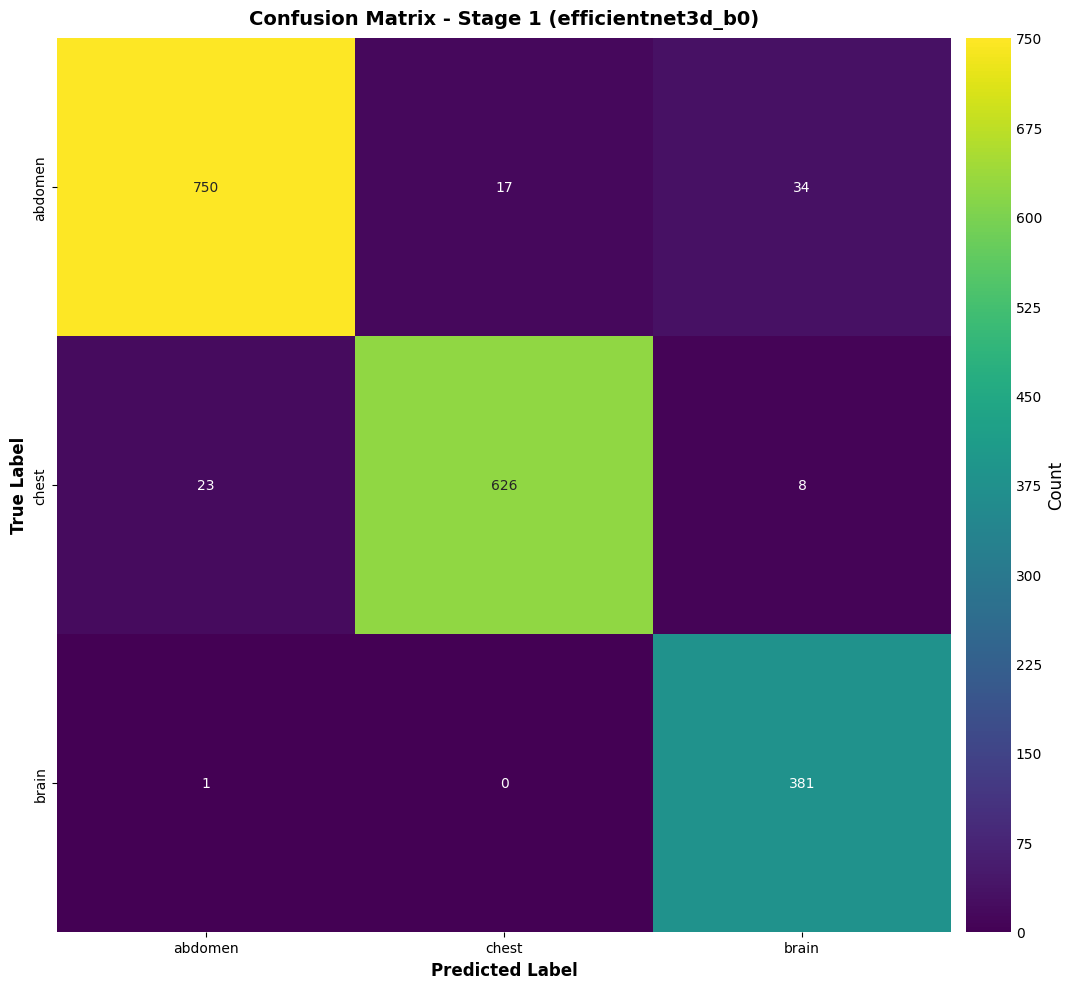

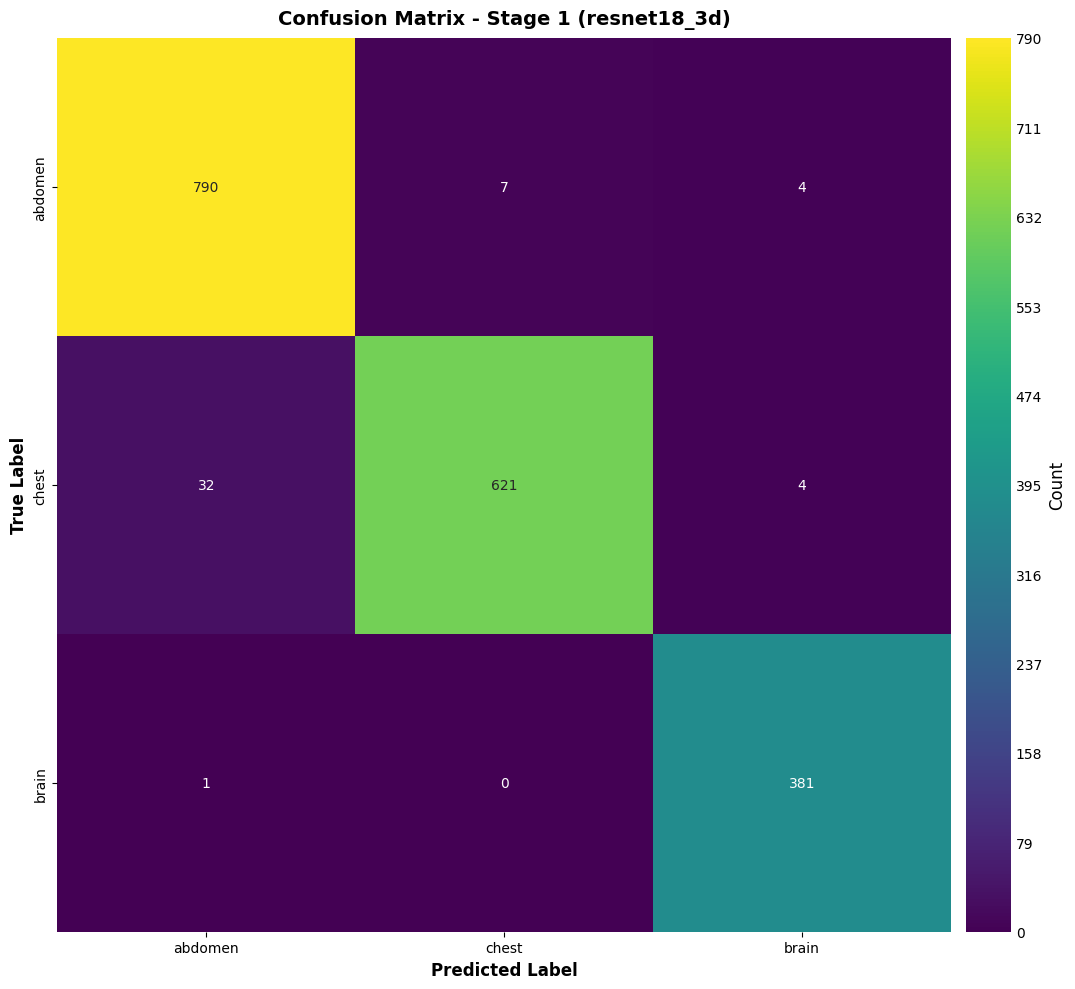

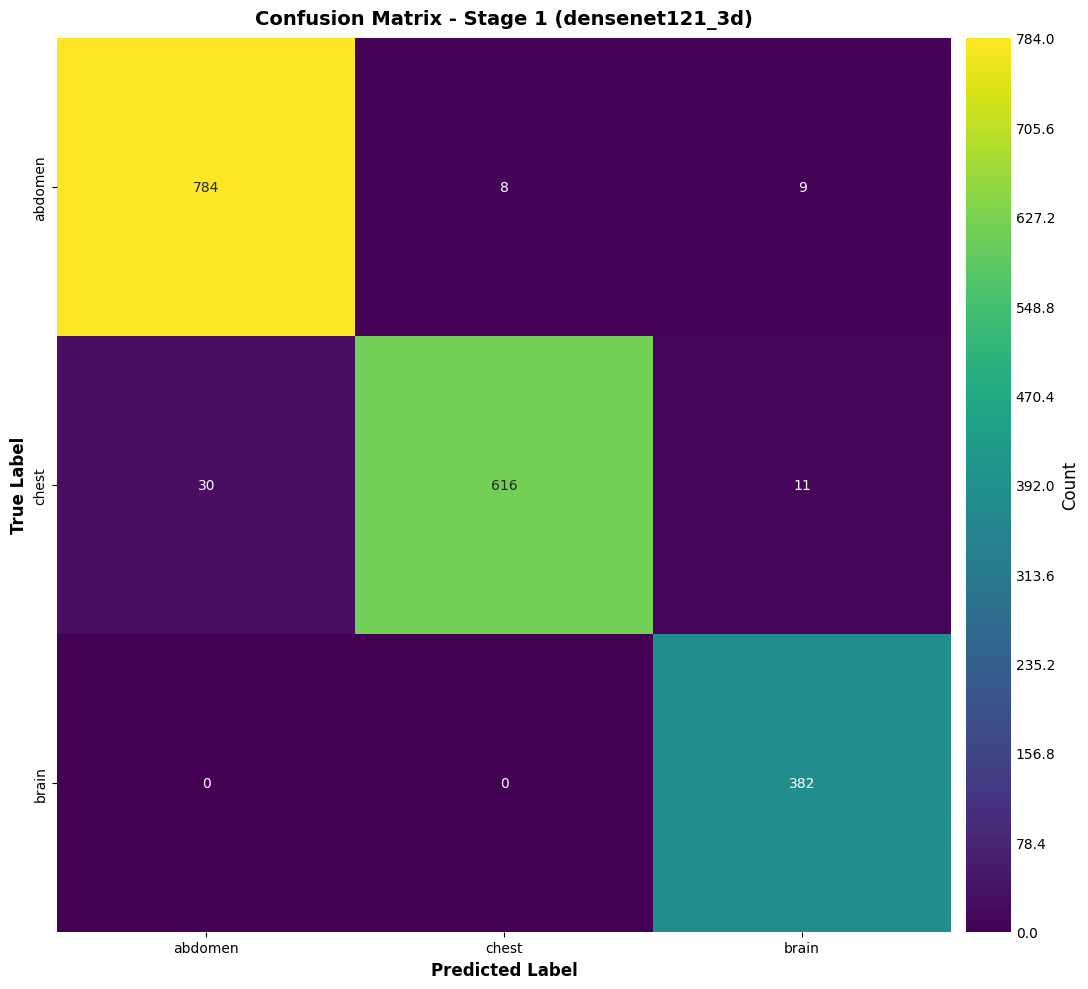

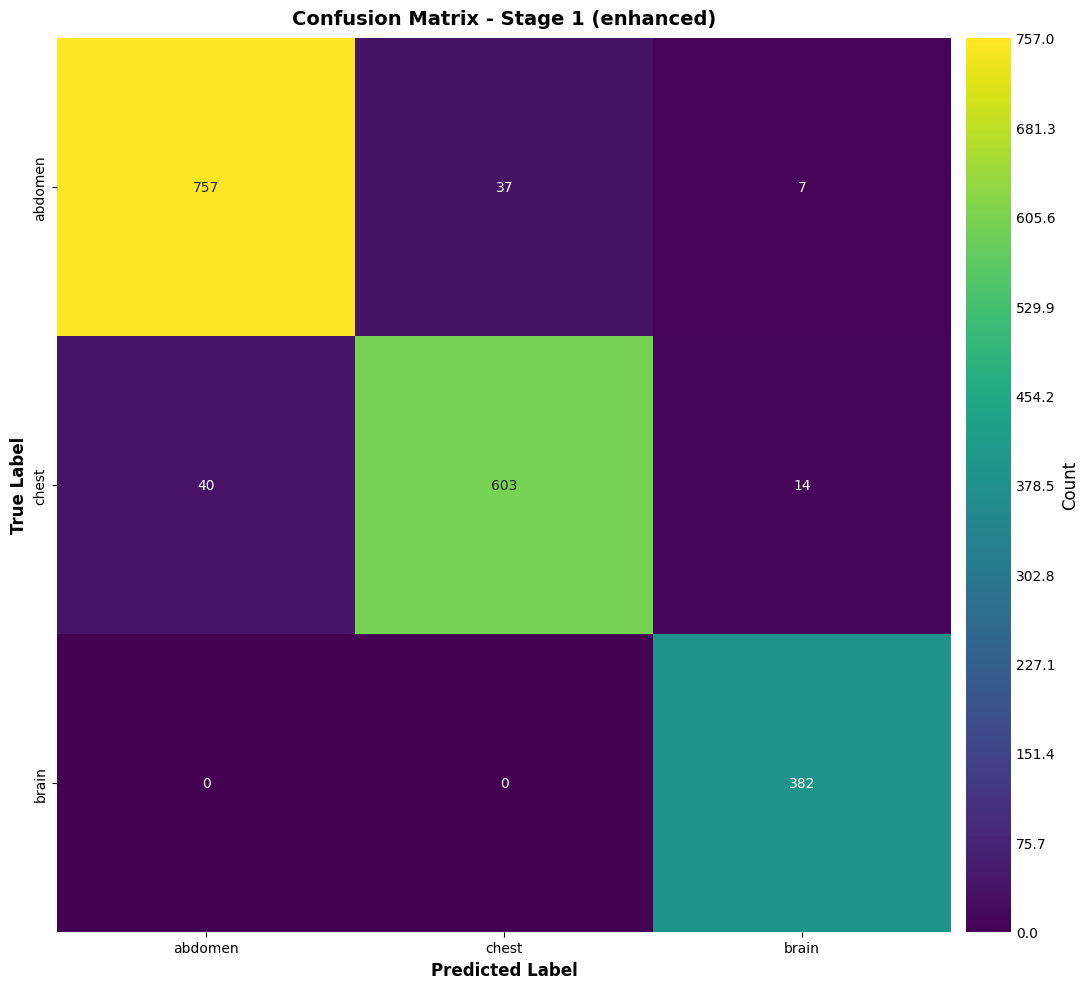

In [7]:
# Stage 1 Confusion Matrices
region_labels = [dataset_info['idx_to_region'][i] for i in range(len(dataset_info['idx_to_region']))]

for arch, results in stage1_results.items():
    plot_confusion_matrix(
        results['labels'],
        results['predictions'],
        f'Confusion Matrix - Stage 1 ({arch})',
        labels=region_labels,
        save_path=f"{PATHS['figures']}/confusion_coarse_{arch}.pgf"
    )

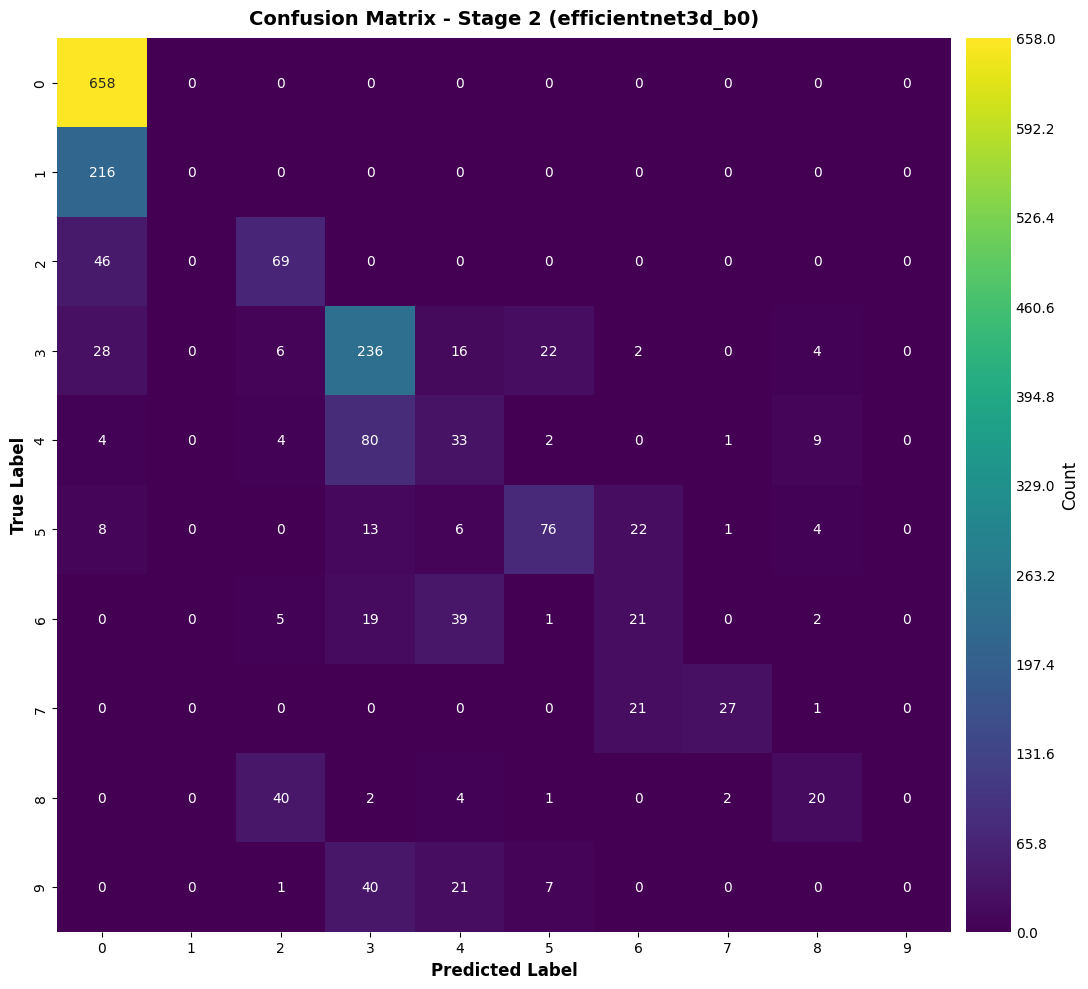

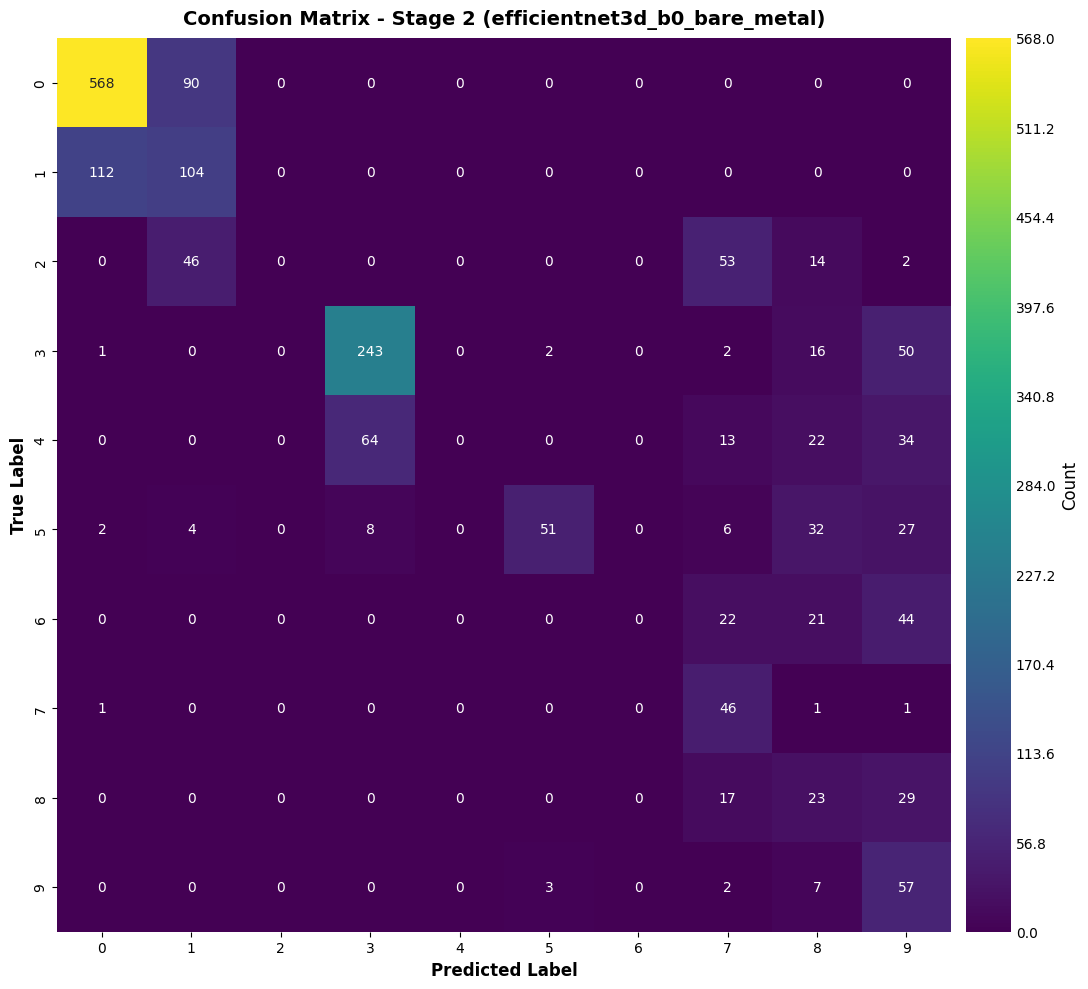

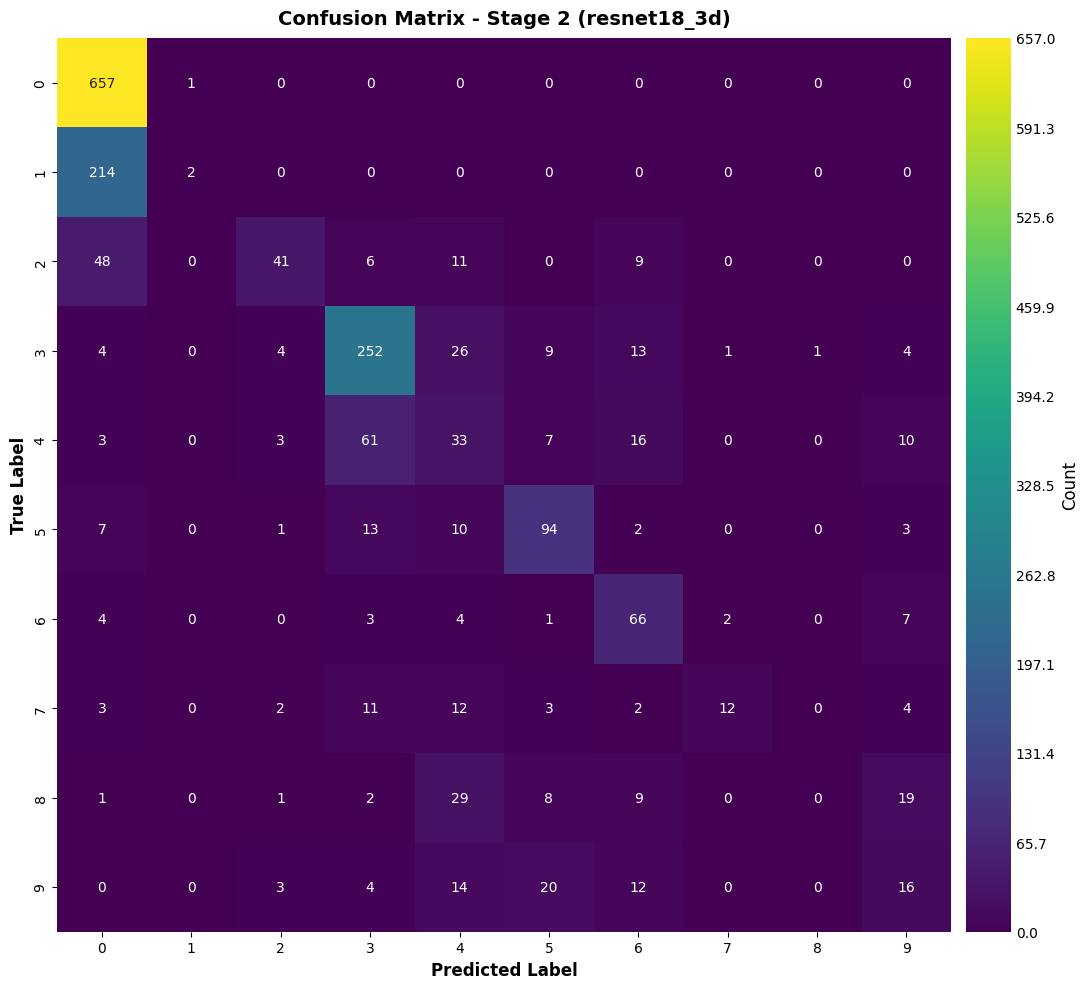

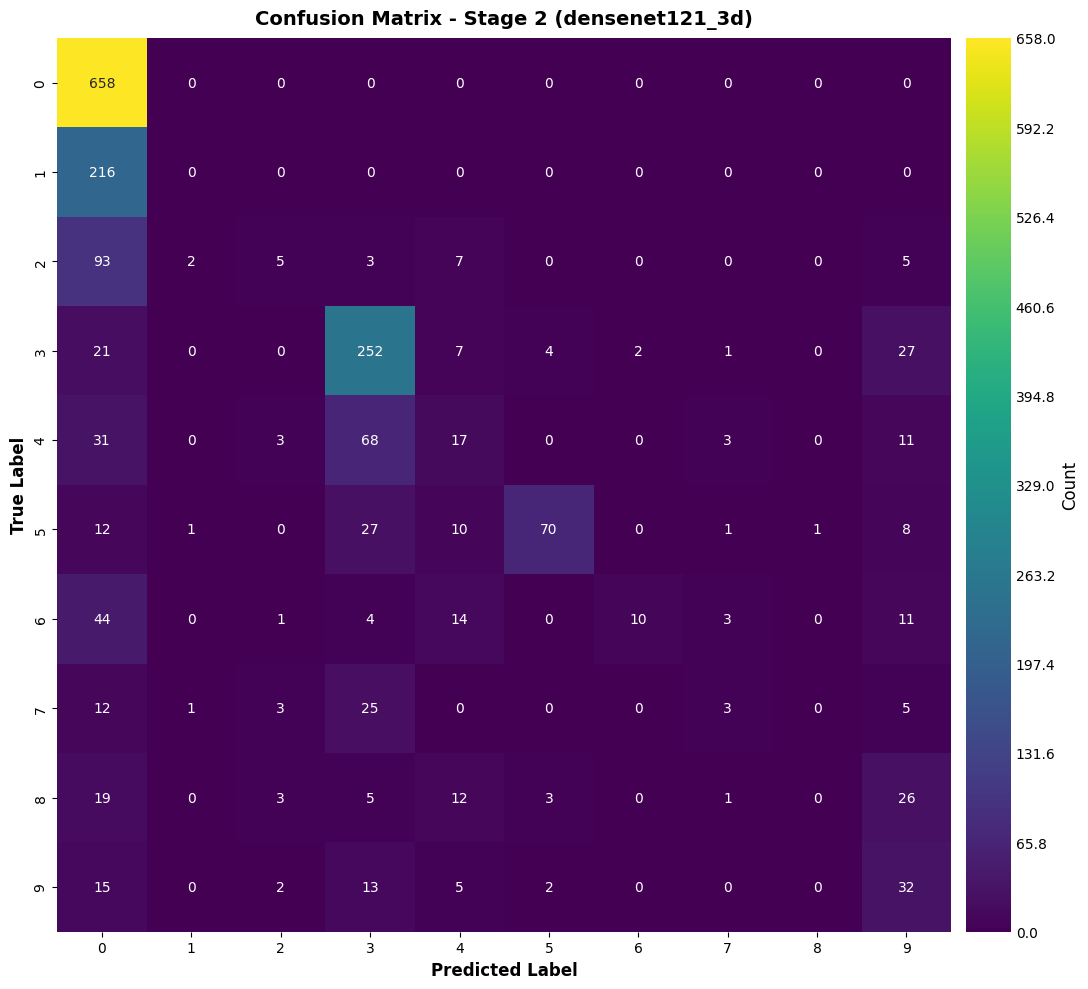

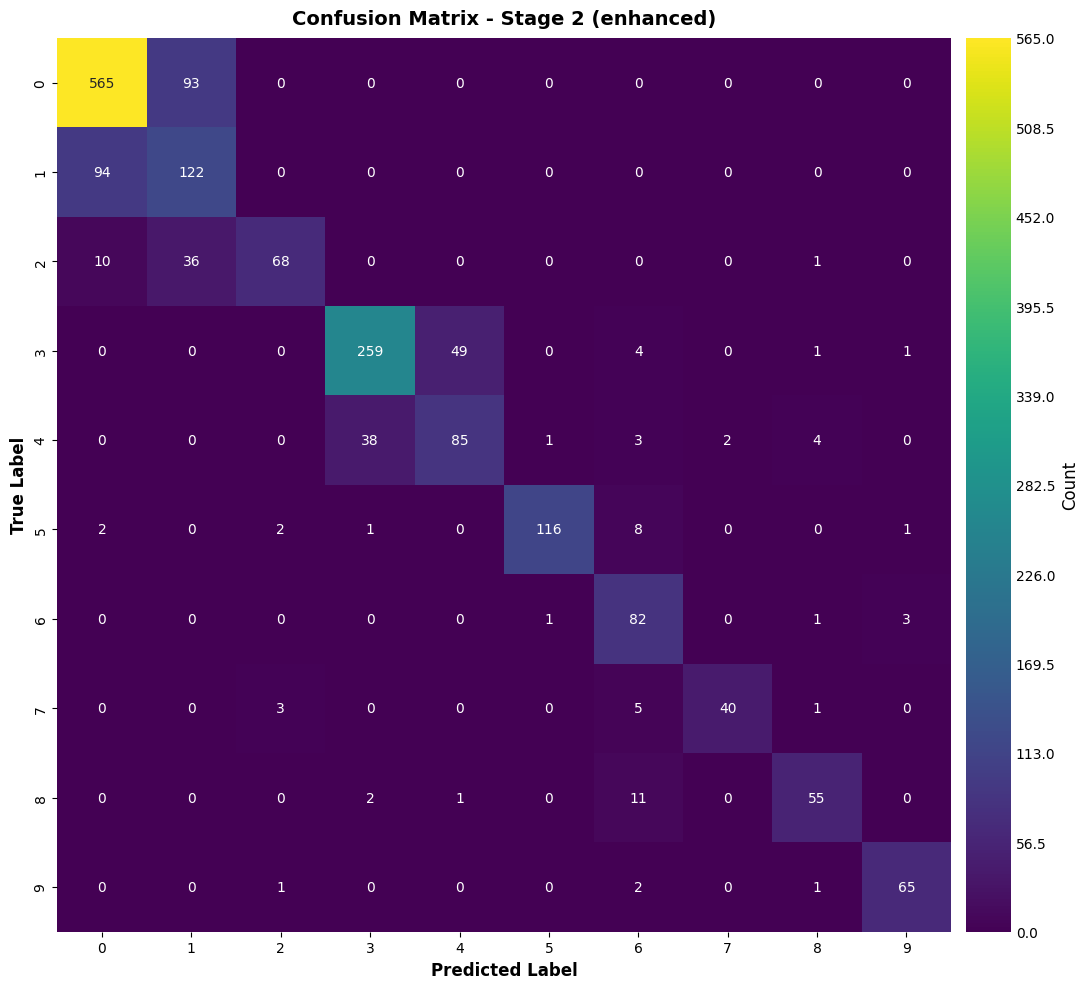

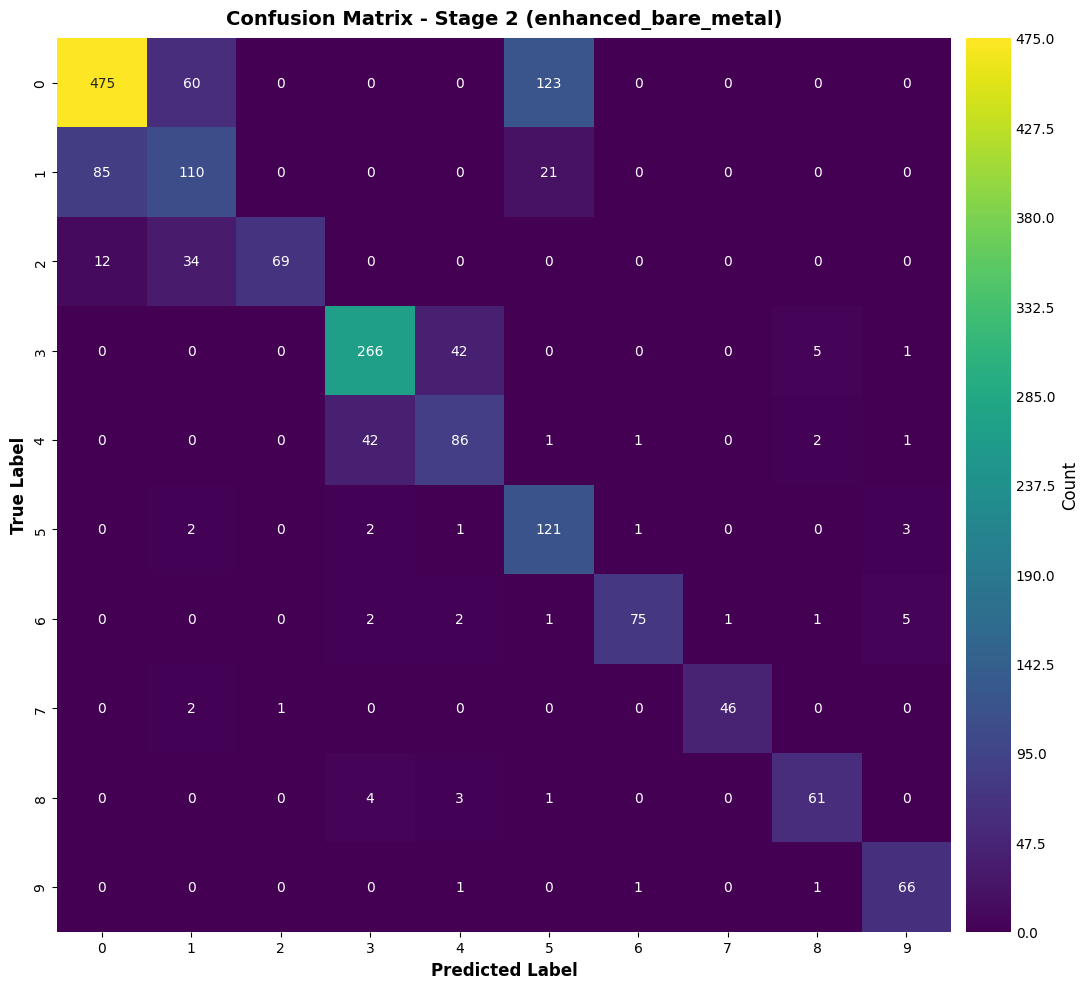

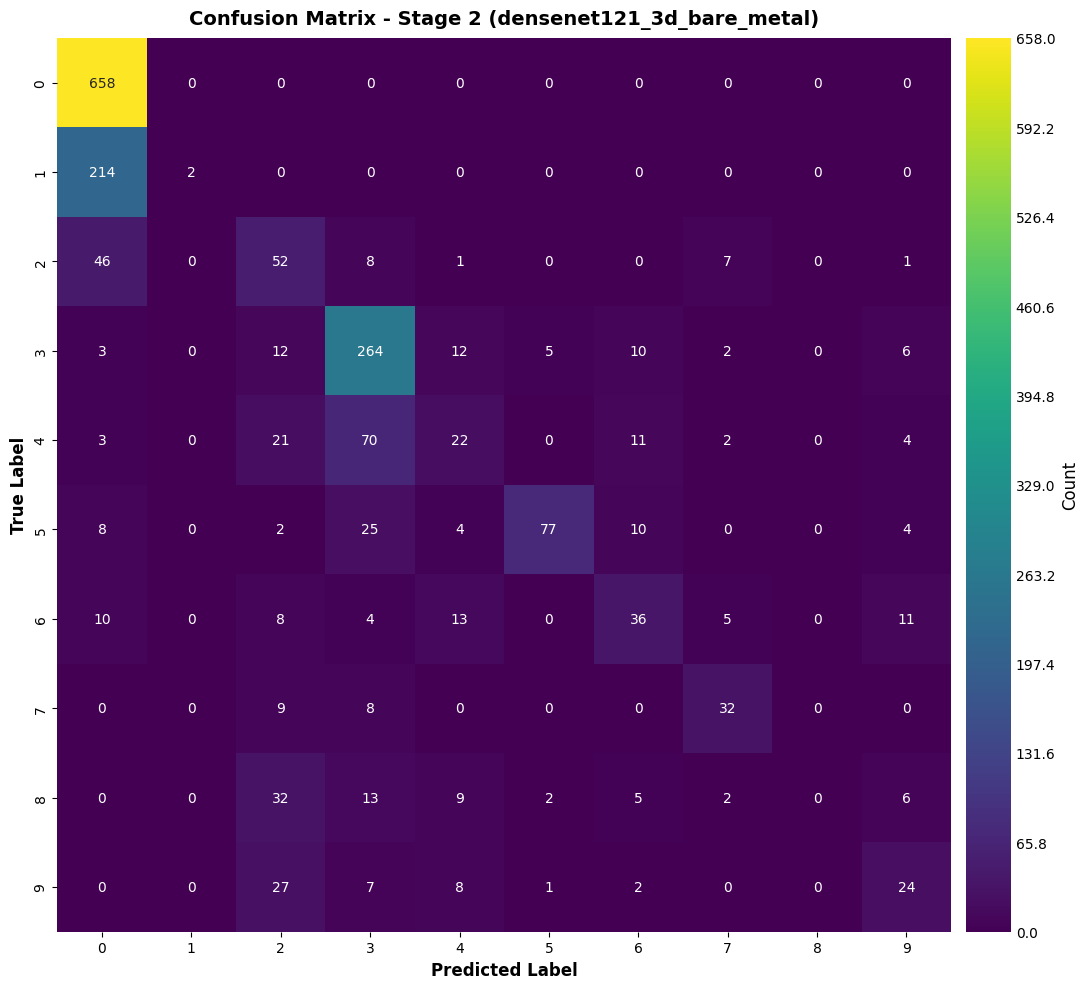

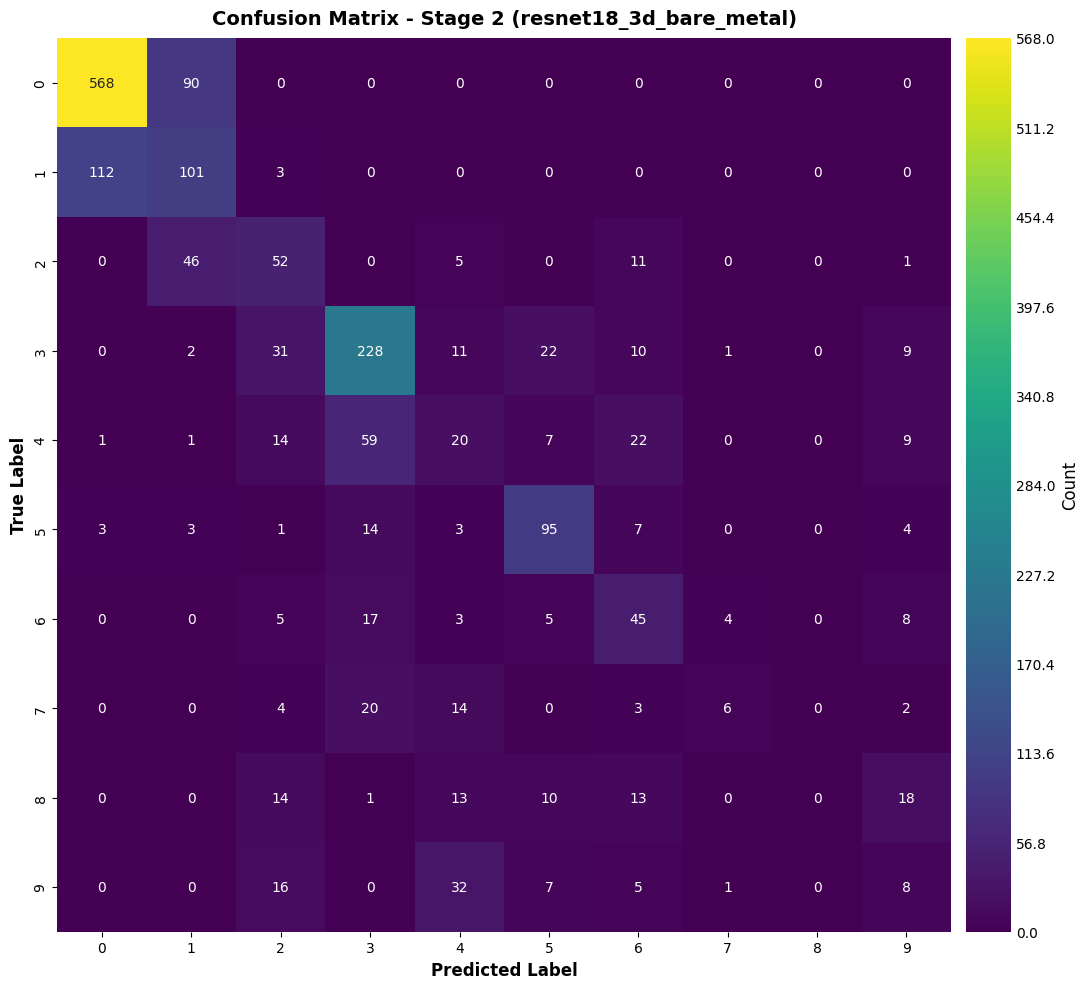

In [8]:
# Stage 2 Confusion Matrices
for arch, results in stage2_results.items():
    fine_unique = sorted(list(set(results['labels'])))
    fine_labels_names = [str(i) for i in fine_unique]
    
    plot_confusion_matrix(
        results['labels'],
        results['predictions'],
        f'Confusion Matrix - Stage 2 ({arch})',
        labels=fine_labels_names,
        save_path=f"{PATHS['figures']}/confusion_fine_{arch}.pgf"
    )

## 6. ROC Curves (Stage 1)

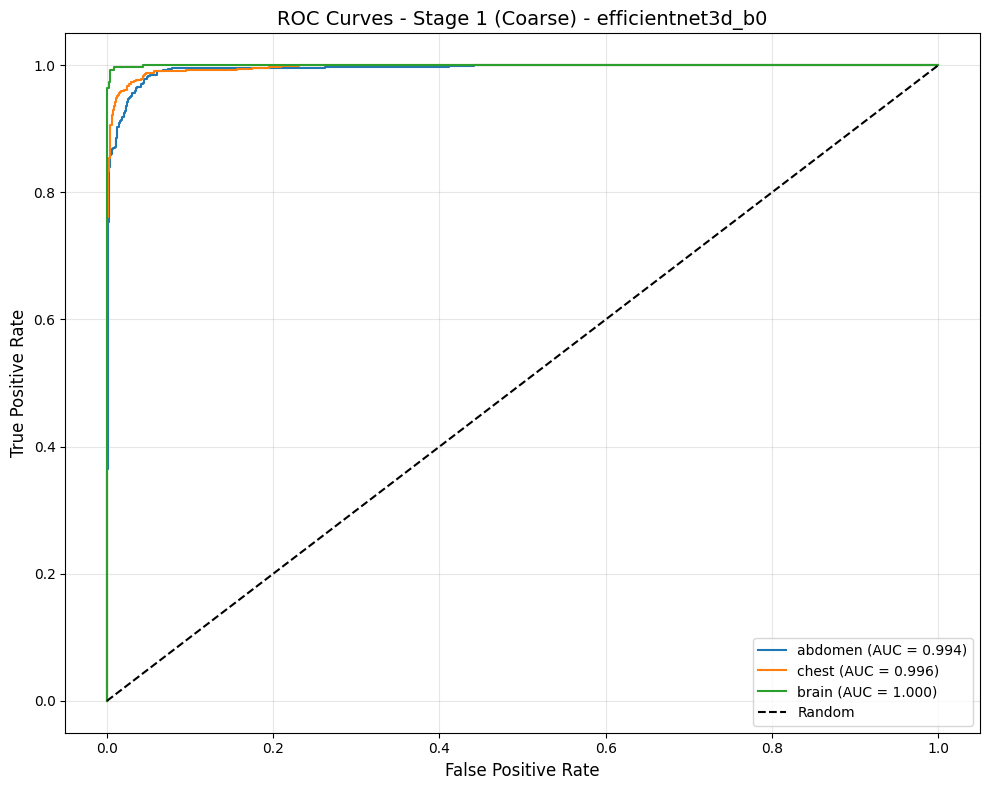

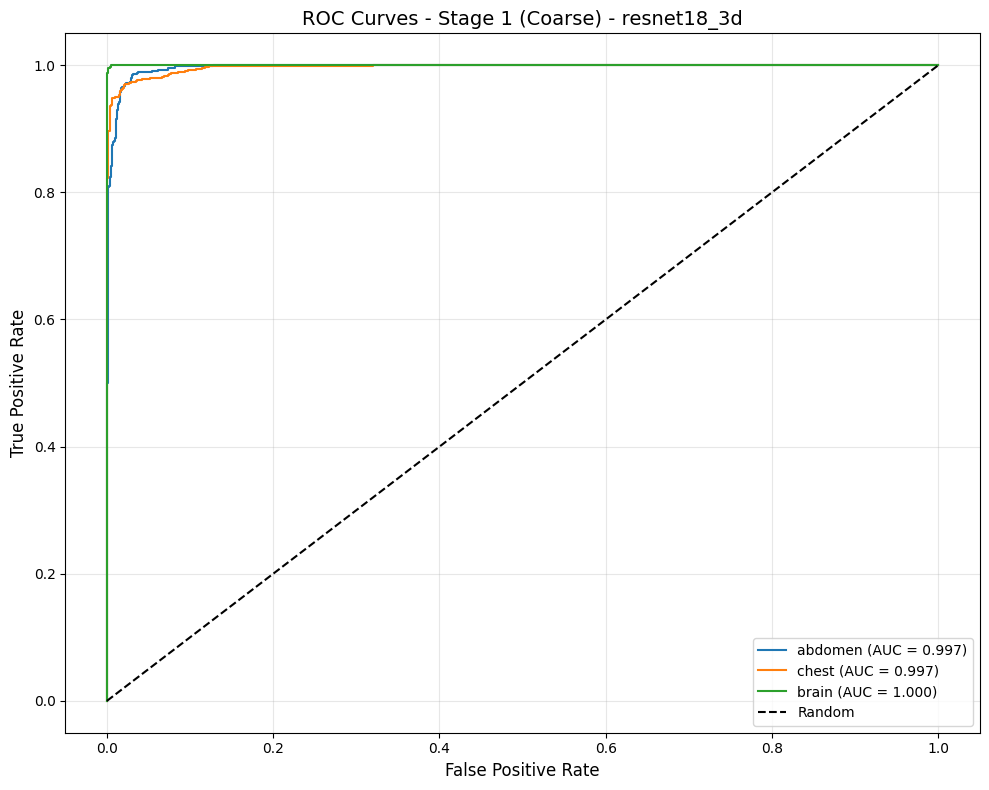

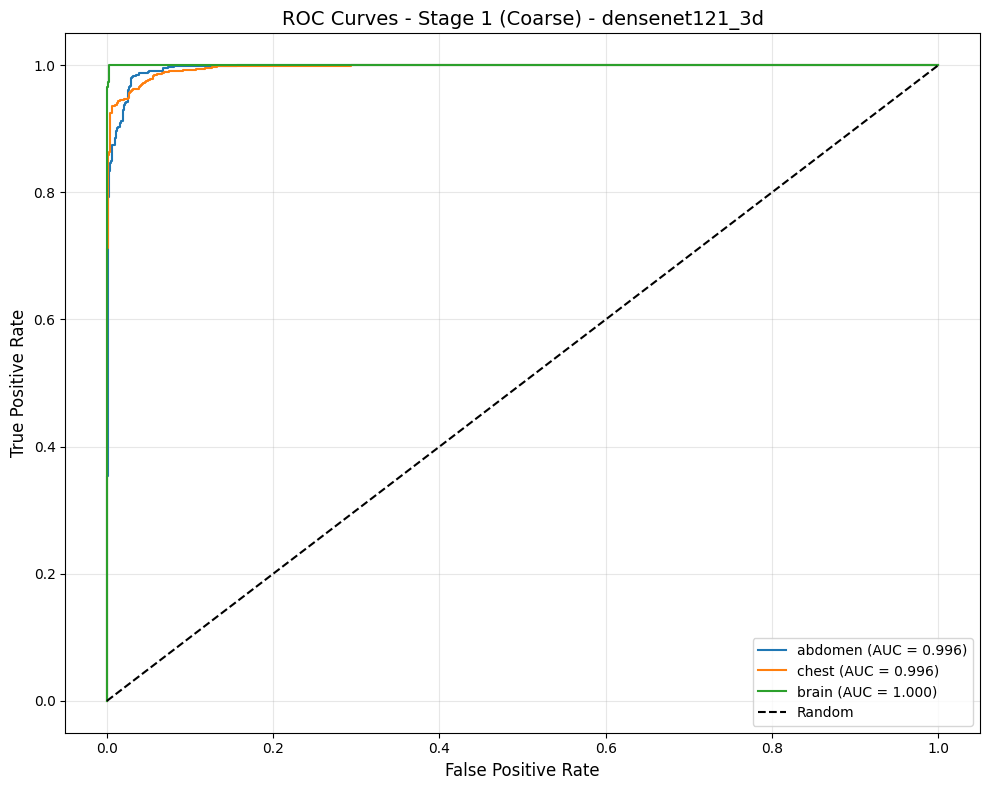

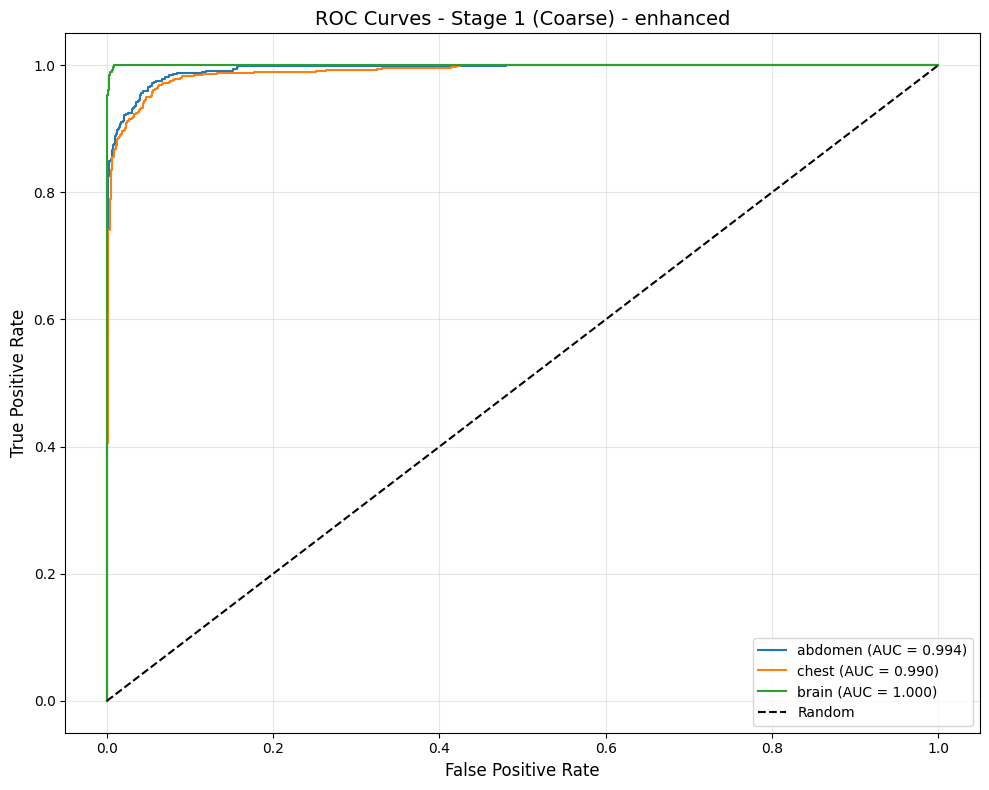

In [9]:
# ROC Curves for Stage 1 (Coarse Classification)
for arch, results in stage1_results.items():
    if 'probs' not in results:
        continue
    
    y_true = results['labels']
    y_probs = results['probs']
    
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=list(range(num_coarse_classes)))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(num_coarse_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        region_name = region_idx_to_name[i]
        plt.plot(fpr, tpr, label=f'{region_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - Stage 1 (Coarse) - {arch}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{PATHS['figures']}/roc_stage1_{arch}.pgf", bbox_inches="tight", pad_inches=0.05, dpi=150)
    plt.show()

## 6. ROC Curves (Stage 2 - Fine Classification)

Generating One-vs-Rest ROC curves for each anatomical region.

In [10]:

# ROC Curves for Stage 2 (Fine Classification)
# Iterates through each architecture and each region to plot fine-grained class performance

for arch, results in stage2_results.items():
    if 'per_region' not in results:
        print(f"Skipping {arch}: No per-region data found.")
        continue
    
    print(f"\nGenerating ROC curves for: {arch}")
    region_data = results['per_region']
    
    for r_name, r_res in region_data.items():
        y_true = r_res['labels']
        y_probs = r_res['probs']
        
        if len(y_true) == 0:
            print(f"  -> Skipping region {r_name}: No data.")
            continue
            
        # Check if y_probs is empty or 1D (this can happen if region had no test samples)
        if len(y_probs) == 0 or y_probs.ndim != 2:
            print(f"  -> Skipping region {r_name}: Invalid probability shape.")
            continue
        
        num_classes = y_probs.shape[1]
        
        # Binarize labels for One-vs-Rest
        # classes are 0..N-1
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        
        # Handle binary case
        if num_classes == 2 and y_true_bin.shape[1] == 1:
            y_true_bin = np.hstack((1 - y_true_bin, y_true_bin))
            
        plt.figure(figsize=(10, 8))
        
        # Plot ROC for each class
        for i in range(num_classes):
            if i < y_true_bin.shape[1]:
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - Stage 2 ({r_name.capitalize()}) - {arch}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        save_path = f"{PATHS['figures']}/roc_stage2_{r_name}_{arch}.pgf"
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05, dpi=150)
        print(f"  -> Saved {os.path.basename(save_path)}")
        plt.close()



Generating ROC curves for: efficientnet3d_b0
  -> Skipping region abdomen: Invalid probability shape.
  -> Skipping region chest: Invalid probability shape.
  -> Skipping region brain: Invalid probability shape.

Generating ROC curves for: efficientnet3d_b0_bare_metal
  -> Skipping region abdomen: Invalid probability shape.
  -> Skipping region chest: Invalid probability shape.
  -> Skipping region brain: Invalid probability shape.

Generating ROC curves for: resnet18_3d
  -> Skipping region abdomen: Invalid probability shape.
  -> Skipping region chest: Invalid probability shape.
  -> Skipping region brain: Invalid probability shape.

Generating ROC curves for: densenet121_3d
  -> Skipping region abdomen: Invalid probability shape.
  -> Skipping region chest: Invalid probability shape.
  -> Skipping region brain: Invalid probability shape.

Generating ROC curves for: enhanced
  -> Skipping region abdomen: Invalid probability shape.
  -> Skipping region chest: Invalid probability shap

## 7. Summary

In [11]:
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"\nStage 1 (Coarse) models evaluated: {len(stage1_results)}")
print(f"Stage 2 (Fine) models evaluated: {len(stage2_results)}")

if stage1_results:
    best_stage1 = max(stage1_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"\nBest Stage 1 model: {best_stage1[0]} (Accuracy: {best_stage1[1]['accuracy']:.4f})")

if stage2_results:
    best_stage2 = max(stage2_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"Best Stage 2 model: {best_stage2[0]} (Accuracy: {best_stage2[1]['accuracy']:.4f})")


ANALYSIS COMPLETE

Stage 1 (Coarse) models evaluated: 4
Stage 2 (Fine) models evaluated: 8

Best Stage 1 model: resnet18_3d (Accuracy: 0.9739)
Best Stage 2 model: enhanced (Accuracy: 0.7918)
